# 🧠 Project 3 – Income Classification using Neural Networks

## 1. 📌 Introduction

### Project Title
**Predicting Loan Default Risk Using Census Income Data**

### Objective
To build a neural network model that classifies individuals as low-risk or high-risk loan applicants, based on demographic and socio-economic data from the UCI Census Income dataset.

### Task Definition
- **Task Type**: Binary classification (income > $50K or ≤ $50K)
- **Advanced Method**: Feedforward Neural Network with regularization techniques
- **Dataset**: UCI Census Income (Adult) Dataset

### Background
Financial institutions face the constant challenge of determining whether a loan applicant is likely to default. Traditionally, this involves credit history and financial statements—but what if we could leverage broader demographic and employment features to predict credit risk?

By classifying whether a person earns more than $50K per year using neural networks, we indirectly estimate their income capacity, a crucial factor in loan repayment ability. High-income individuals are typically lower-risk, while lower-income applicants may pose greater risk, especially without collateral or prior credit history.

## 2. 📂 Dataset Overview & Significance

### Dataset Details
- **Source**: [UCI Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)
- **Structure**: ~48,000 rows, 14 feature columns plus target variable
- **Target Variable**: `income` (binary: >$50K or ≤$50K)
- **Class Distribution**: Approximately 75% ≤$50K, 25% >$50K (imbalanced)

### Why This Project Matters

This project addresses a critical business need in the financial sector: accurately assessing loan default risk. Traditional methods rely heavily on credit history, which disadvantages those with limited credit records (the "thin file" problem). By leveraging demographic and socioeconomic data, we can create more inclusive risk assessment models.

### Why Income Prediction for Credit Scoring

Income level is one of the strongest predictors of loan repayment ability. By using machine learning to predict whether someone earns above $50K annually, we create a proxy measure for financial stability and repayment capacity. This approach can:

- Supplement traditional credit scoring for more holistic evaluation
- Enable assessment of applicants with limited credit history
- Provide early warning indicators for potential defaults

### Why the Census Dataset is Valuable

The UCI Census Income dataset is particularly well-suited for this task because it contains:

- Rich demographic variables (age, education, occupation) that correlate with financial stability
- Employment information that indicates income consistency
- A diverse representation of the population across various socioeconomic levels
- High-quality data collected through rigorous census methodology

## 3. 🧹 Data Cleaning & Preprocessing

In [ ]:
# === General Libraries ===
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

# === Data Preprocessing ===
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # , OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === Evaluation Metrics ===
from sklearn.metrics import (
    # accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    # mean_squared_error, r2_score, mean_absolute_error,
    roc_curve, roc_auc_score # , auc
)

# === TensorFlow / Keras ===
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    # Input, Flatten, Embedding, Concatenate, Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

# === Others ===
import os
import math

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

### 3.1 Loading the Dataset
Let's start by loading the UCI Census Income dataset and exploring its initial structure.

In [2]:
# fetch dataset 
census_income = fetch_ucirepo(id=20) # https://archive.ics.uci.edu/dataset/20/census+income
# print(census_income.metadata) # metadata 
# print(census_income.variables) # variable information 
df = pd.concat([census_income.data.features, census_income.data.targets], axis=1)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [3]:
df.isnull().sum() # check for null values

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [4]:
# Showing the Values in Each Column
for col in df.columns:
    print(f"Column: `{col}`")
    print(df[col].unique())
    print("\n")

Column: `age`
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]


Column: `workclass`
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]


Column: `fnlwgt`
[ 77516  83311 215646 ... 173449  89686 350977]


Column: `education`
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']


Column: `education-num`
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]


Column: `marital-status`
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']


Column: `occupation`
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' '

### 3.2 Data Cleaning Steps

The key data cleaning steps include:
1. Handling missing values (replacing `'?'` with `NaN` and dropping rows)
2. Transforming categorical variables (age binning)
3. Feature engineering (creating capital-profit from gain/loss)
4. Standardizing the target variable
5. Removing irrelevant features

In [5]:
# Data Cleaning
df[df=='?']=np.nan # Replacing '?' with NaN
df=df.dropna(axis=0) # Dropping all rows with NaN values
# df = df[~(df['native-country'] == "?") | (df['native-country'].isnull())] # ALTERNATIVE Removing all rows with Unknown Countries as part of data cleaning process

In [6]:
df['age'] = pd.cut(df['age'], bins=[0, 30, 60, 100], labels=['Young', 'Middle-aged', 'Old']) # Categrise Age into Young, Middle-aged and Old
# df['age'] = df['age'].astype('category') # Convert categorical variables to 'category' dtype
df['capital-metrics'] = df['capital-gain'] - df['capital-loss']
df['capital-profit'] = df['capital-metrics'].apply(lambda x: 0 if x < 0 else 1)
df.drop(columns=['capital-gain', 'capital-loss', 'capital-metrics'], inplace=True)

In [7]:
df.info() # check the data types and null values

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45222 non-null  category
 1   workclass       45222 non-null  object  
 2   fnlwgt          45222 non-null  int64   
 3   education       45222 non-null  object  
 4   education-num   45222 non-null  int64   
 5   marital-status  45222 non-null  object  
 6   occupation      45222 non-null  object  
 7   relationship    45222 non-null  object  
 8   race            45222 non-null  object  
 9   sex             45222 non-null  object  
 10  hours-per-week  45222 non-null  int64   
 11  native-country  45222 non-null  object  
 12  income          45222 non-null  object  
 13  capital-profit  45222 non-null  int64   
dtypes: category(1), int64(4), object(9)
memory usage: 4.9+ MB


In [8]:
# Standardizing the income column values
df['income'] = df['income'].str.replace('.', '')
df['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
# df['income'] = df['income'].astype('category')
df['income'].value_counts()

income
0    34014
1    11208
Name: count, dtype: int64

In [9]:
# Dropping Irrelevant Columns
df.drop(columns=['fnlwgt', 'education'], inplace=True) # Dropping the fnlwgt and education columns as they are not relevant to the analysis

In [10]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

## 4. 🔍 Exploratory Data Analysis

Now that we've cleaned the data, let's explore the relationships between different features and our target variable. This will help us understand the underlying patterns in the data.

In [11]:
# Separate features
numerical_features_temp = df.select_dtypes(include=['int64', 'float64']).drop(columns=['income', 'capital-profit']).columns.tolist()
categorical_features_temp = df.select_dtypes(include=['object', 'category']).columns.tolist()

### 4.1 Analysis of Numerical Features
Let's examine how numerical features like education level and working hours relate to income.

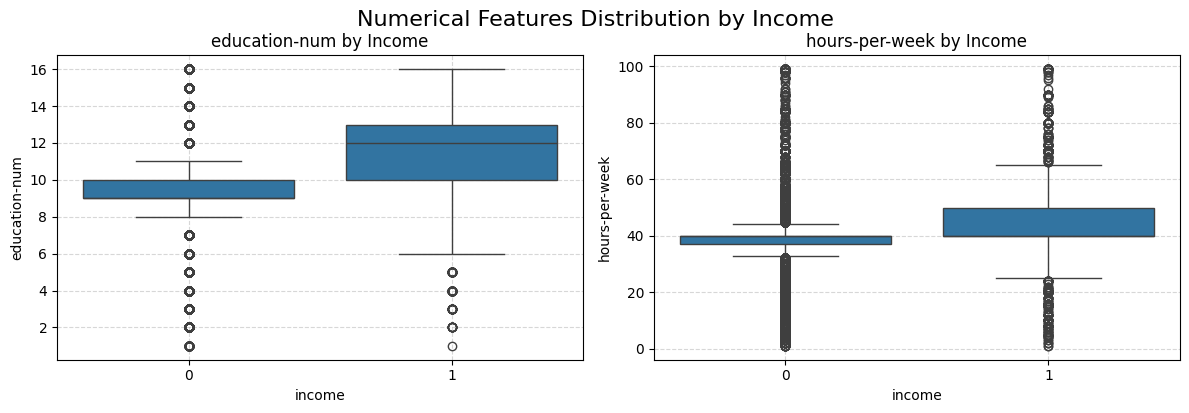

In [12]:
# === NUMERICAL FEATURES ===
num_cols = 2
num_rows = math.ceil(len(numerical_features_temp) / num_cols)
plt.figure(figsize=(num_cols * 6, num_rows * 4))

for i, feature in enumerate(numerical_features_temp):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(data=df, x='income', y=feature)
    plt.title(f"{feature} by Income")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

plt.suptitle("Numerical Features Distribution by Income", y=1.02, fontsize=16)
plt.show()

### 4.2 Analysis of Categorical Features
Now let's look at how categorical variables like occupation, relationship status, and other demographic factors correlate with income levels.

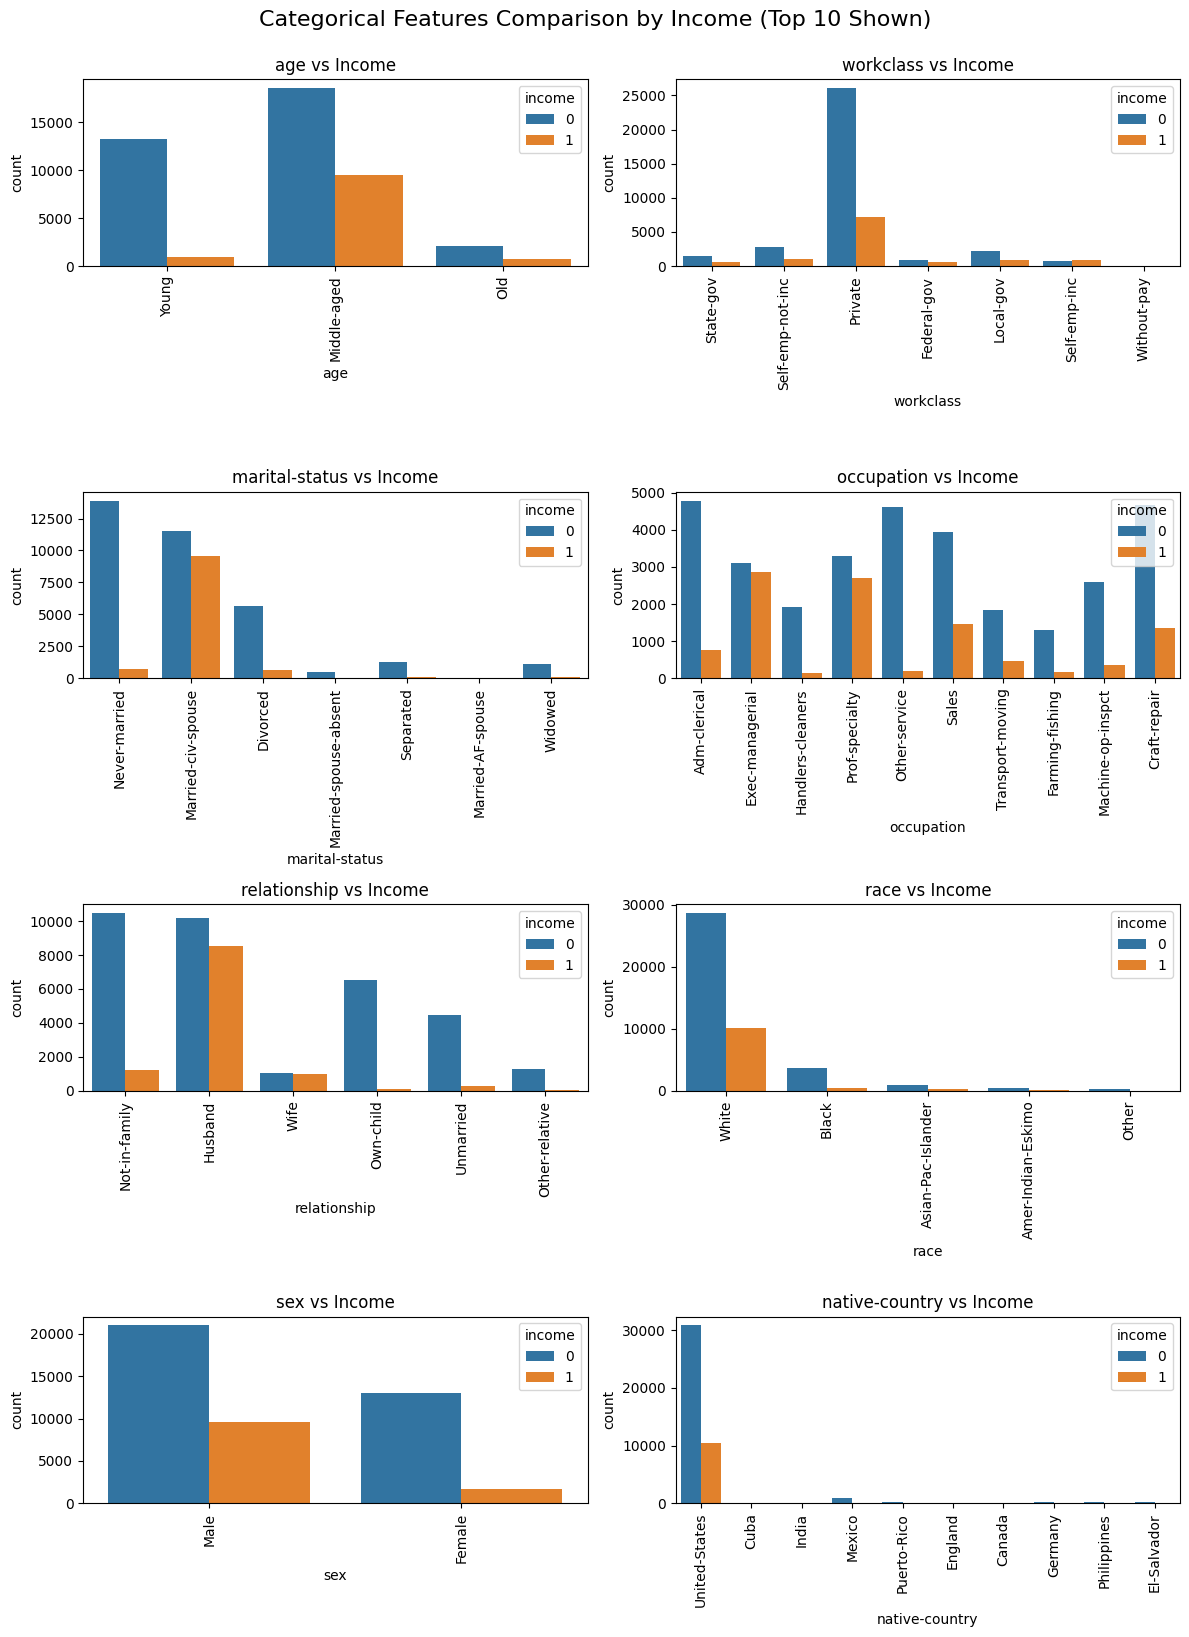

In [13]:
# === CATEGORICAL FEATURES ===
cat_cols = 2
cat_rows = math.ceil(len(categorical_features_temp) / cat_cols)
plt.figure(figsize=(cat_cols * 6, cat_rows * 4))

for i, feature in enumerate(categorical_features_temp):
    plt.subplot(cat_rows, cat_cols, i + 1)

    # Get top 10 most common categories (if needed)
    top_categories = df[feature].value_counts().nlargest(10).index
    filtered_df = df[df[feature].isin(top_categories)]

    sns.countplot(data=filtered_df, x=feature, hue='income')
    plt.title(f"{feature} vs Income")
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.suptitle("Categorical Features Comparison by Income (Top 10 Shown)", y=1.02, fontsize=16)
plt.show()

## 5. 🧠 Data Preprocessing & Feature Engineering

Now we'll prepare our data for modeling by creating appropriate preprocessing pipelines for both numerical and categorical features.

In [14]:
target = 'income' # Setting the target variable

# Create preprocessing pipelines for numerical and categorical data
numeric_features = [f for f in df.select_dtypes(include=[np.number, 'number', 'float64', 'int64', 'float32', 'int32']).columns.to_list() if f != target]
categorical_features = [f for f in df.select_dtypes(include=["object", "category"]).columns.to_list() if f != target ]

# Numeric pipeline with standard scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Categorical pipeline with one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(
        # drop='first',
        # sparse_output=False, # Return dense array
        handle_unknown="ignore"
    )),
    # ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


### 5.1 Train-Test Split and Class Distribution
Let's create our train and test sets, ensuring that they maintain the same class distribution as the original dataset.

In [15]:
# Create X and y
X = df.drop(columns=[target])
y = df[target]

In [16]:
# First split: separate out the test set (80% train+val, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Verify the split proportions
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.2%} of total)")

# Check class distribution in each set
print(f"\nClass distribution:")
print(f"Overall: {y.value_counts(normalize=True).to_dict()}")
print(f"Test: {y_test.value_counts(normalize=True).to_dict()}")

Test set size: 9045 (20.00% of total)

Class distribution:
Overall: {0: 0.7521560302507629, 1: 0.2478439697492371}
Test: {0: 0.7521282476506357, 1: 0.2478717523493643}


Class distribution in dataset:
income
0    0.752156
1    0.247844
Name: proportion, dtype: float64


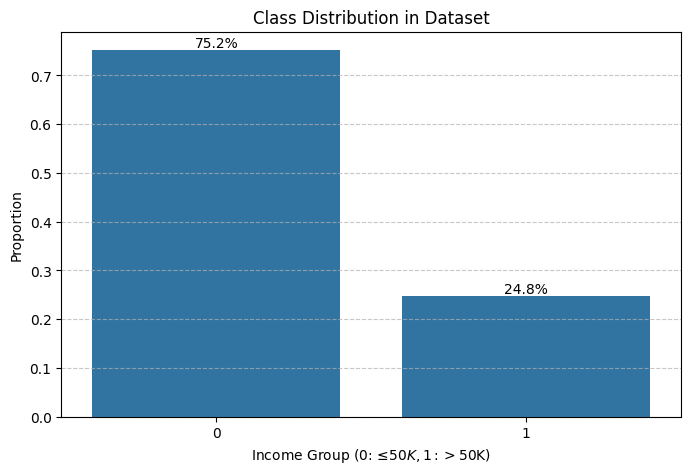

In [17]:
# Check class distribution in the dataset
class_distribution = y.value_counts(normalize=True)
print(f"Class distribution in dataset:\n{class_distribution}")

# Create a bar plot of the class distribution
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Income Group (0: ≤$50K, 1: >$50K)')
plt.ylabel('Proportion')

# Add percentage labels on top of the bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{height:.1%}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# Calculate imbalance ratio
majority_class = class_distribution.max()
minority_class = class_distribution.min()
imbalance_ratio = majority_class / minority_class
print(f"Imbalance ratio (majority:minority): {imbalance_ratio:.2f}:1")

Imbalance ratio (majority:minority): 3.03:1


### 5.2 Handling Class Imbalance
Since our dataset has an imbalance ratio of about 3:1, we'll calculate class weights to ensure the model pays sufficient attention to the minority class during training.

In [19]:
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
class_counts = np.bincount(y_train)
class_weights = n_samples / (n_classes * class_counts)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"\nClass weights for model training:\n{class_weight_dict}")


Class weights for model training:
{0: np.float64(0.6647495498144133), 1: np.float64(2.0174548293553425)}


## 6. 🧠 Modeling Approach

For this classification task, we'll use a feedforward neural network with the following architecture:
- Sequential model with 3 hidden layers (128, 64, 32 neurons)
- BatchNormalization for faster convergence and stability
- Dropout layers (0.3, 0.3, 0.2) for preventing overfitting
- Sigmoid activation in the output layer for binary classification

We'll use 10-fold cross-validation to ensure the robustness of our model's performance, tracking multiple metrics to assess different aspects of model quality. Below we train the model with k-fold cross-validation:

In [ ]:
# Initialize lists to store metrics and models
fold_metrics = []
fold_models = []

best_model = None
best_metric = -np.inf  # Initialize to very low number
best_fold_index = -1

os.makedirs("fold_models", exist_ok=True)

fold_historys = {}

number_of_folds = 5
number_of_epochs = 50

# KFold CV
kf = KFold(n_splits=number_of_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f'\nFold {fold + 1}/{number_of_folds}')
    checkpoint_path = f'ignore/fold_models/fold_{fold + 1}.keras'

    # Train/Val Split
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Preprocessing
    X_fold_train_processed = preprocessor.fit_transform(X_fold_train).astype('float32')
    X_fold_val_processed = preprocessor.transform(X_fold_val).astype('float32')
    X_test_processed = preprocessor.transform(X_test).astype('float32')

    # Model
    input_dim = X_fold_train_processed.shape[1]
    keras_model = Sequential([
        Dense(256, input_dim=input_dim, activation='relu'), # Dense(128, input_dim=input_dim, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'), # Dense(64, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'), # Dense(32, kernel_initializer='he_uniform'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    keras_model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_auc',  # track AUC for model selection
        mode='max',
        save_best_only=True,
        verbose=0
    )

    history = keras_model.fit(
        X_fold_train_processed, y_fold_train,
        validation_data=(X_fold_val_processed, y_fold_val),
        epochs=number_of_epochs,
        batch_size=64,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, model_checkpoint], # Save the best model based on AUC
        verbose=0
    )

    fold_historys[fold + 1] = history.history

    # Evaluation
    _, accuracy, precision, recall, auc = keras_model.evaluate(X_fold_val_processed, y_fold_val, verbose=0)
    
    # Store results
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc
    })
    
    fold_models.append(keras_model)

    print(f'Fold {fold + 1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
          f'Recall: {recall:.4f}, AUC: {auc:.4f}')

    # Track best model by AUC
    if auc > best_metric:
        best_metric = auc
        best_model = keras_model
        best_fold_index = fold + 1

# Average metrics
avg_metrics = {
    metric: np.mean([fold[metric] for fold in fold_metrics])
    for metric in ['accuracy', 'precision', 'recall', 'auc']
}

print('\nAverage metrics across all folds:')
print(f"Accuracy: {avg_metrics['accuracy']:.4f}")
print(f"Precision: {avg_metrics['precision']:.4f}")
print(f"Recall: {avg_metrics['recall']:.4f}")
print(f"AUC: {avg_metrics['auc']:.4f}")


Fold 1/5
Fold 1 - Accuracy: 0.7868, Precision: 0.5481, Recall: 0.8237, AUC: 0.8839

Fold 2/5
Fold 2 - Accuracy: 0.8033, Precision: 0.5680, Recall: 0.8192, AUC: 0.8906

Fold 3/5
Fold 3 - Accuracy: 0.7939, Precision: 0.5600, Recall: 0.8371, AUC: 0.8933

Fold 4/5
Fold 4 - Accuracy: 0.7898, Precision: 0.5474, Recall: 0.8567, AUC: 0.8924

Fold 5/5
Fold 5 - Accuracy: 0.7928, Precision: 0.5537, Recall: 0.8351, AUC: 0.8872

Average metrics across all folds:
Accuracy: 0.7933
Precision: 0.5555
Recall: 0.8344
AUC: 0.8895


## 7. 📊 Evaluation & Results

### 7.1 Cross-Validation Performance
Let's visualize the performance of our model across the 10 cross-validation folds to assess consistency.

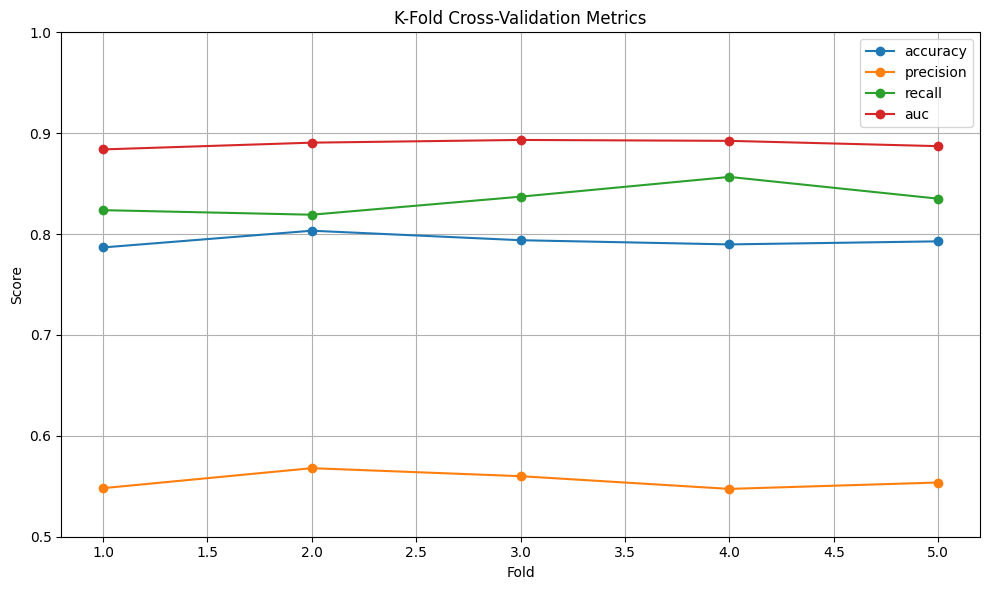

In [21]:
# Convert to DataFrame
df_metrics = pd.DataFrame(fold_metrics)

# Plotting
plt.figure(figsize=(10, 6))
for metric in ['accuracy', 'precision', 'recall', 'auc']:
    plt.plot(df_metrics['fold'], df_metrics[metric], marker='o', label=metric)

plt.title('K-Fold Cross-Validation Metrics')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Report best fold
print(f"\n✅ Best Model is from Fold {best_fold_index} with AUC: {best_metric:.4f}")
best_model_path = f'fold_models/fold_{best_fold_index}.keras'
final_model = load_model(best_model_path)


✅ Best Model is from Fold 3 with AUC: 0.8933


### 7.2 Model Architecture Summary
Let's examine the architecture of our neural network model to understand its complexity.

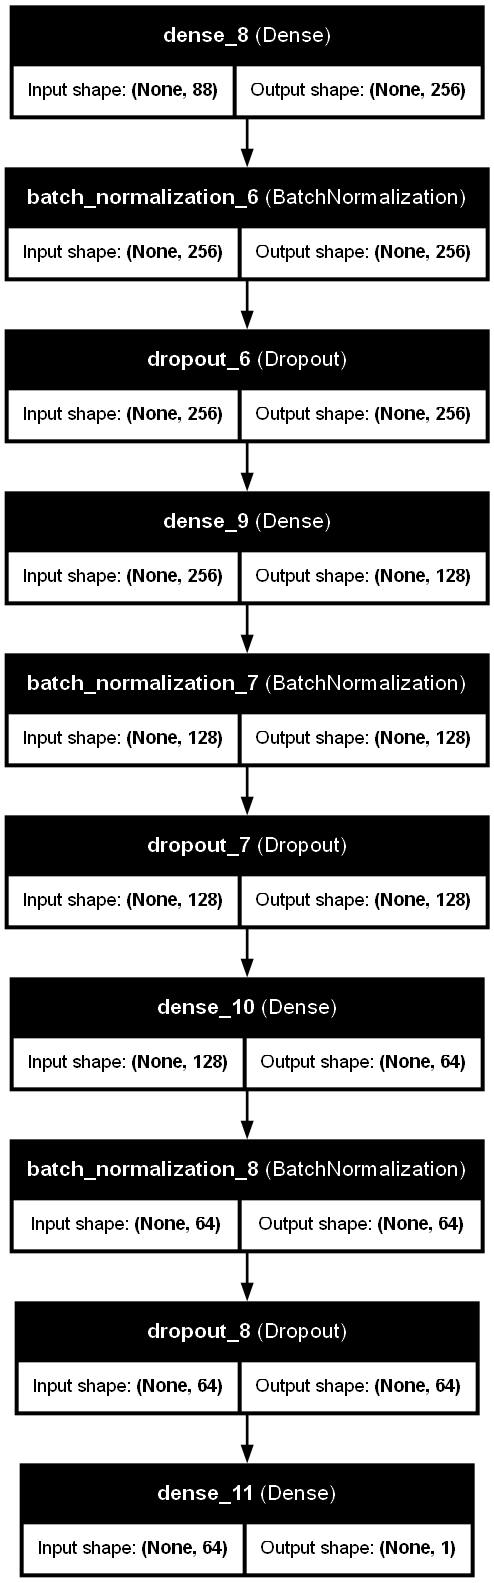

In [30]:
plot_model(
    final_model,
    to_file='ignore/model_plot.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)

In [23]:
keras_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 256)            │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,589 (764.02 KB)

 Trainable params: 64,897 (253.50 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 129,796 (507.02 KB)

### 7.3 Learning Curves
Analyzing the learning curves helps us understand how the model learned over time and whether there are any signs of overfitting or underfitting.

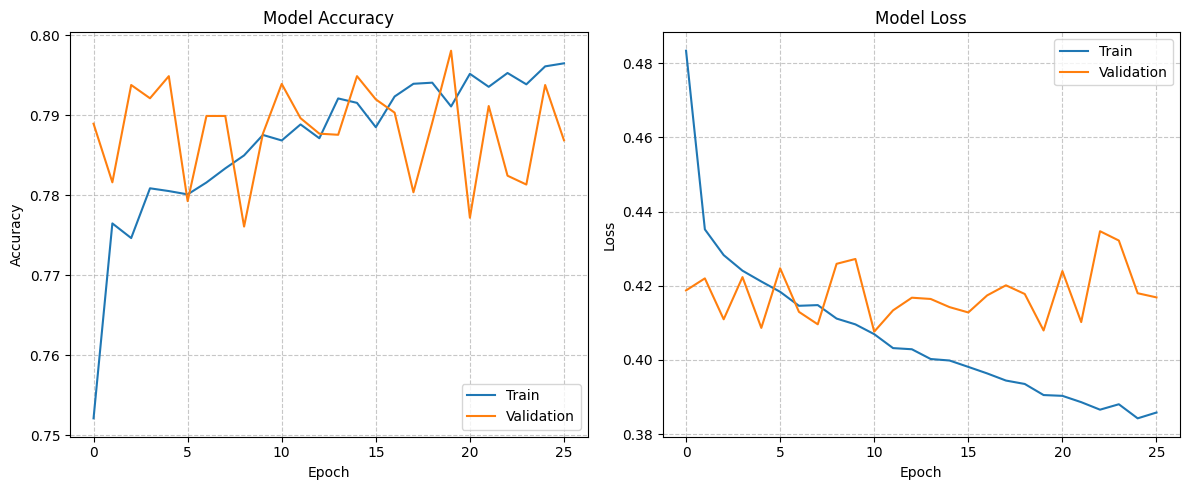

Training completed after 26 epochs
Final training loss: 0.3858
Final training accuracy: 0.7965
Final validation loss: 0.4169
Final validation accuracy: 0.7869


In [25]:
history = fold_historys[best_fold_index]

# Plot learning curves
plt.figure(figsize=(12, 5))

# Plot training accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot training loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print information about training
print(f"Training completed after {len(history['loss'])} epochs")
print(f"Final training loss: {history['loss'][-1]:.4f}")
print(f"Final training accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
print(f"Final validation accuracy: {history['val_accuracy'][-1]:.4f}")

### 7.4 Final Test Set Evaluation
Now let's evaluate our best model on the unseen test set to get an unbiased estimation of its performance.

In [26]:
# Preprocess the test set
X_test_processed = preprocessor.transform(X_test).astype('float32')

# Predict and evaluate
y_test_pred_probs = final_model.predict(X_test_processed).flatten()
y_test_pred = (y_test_pred_probs > 0.5).astype("int32")

# Metrics
print("\n📊 Final Test Set Evaluation:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_pred_probs):.4f}")

283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

📊 Final Test Set Evaluation:
[[5242 1561]
 [ 348 1894]]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      6803
           1       0.55      0.84      0.66      2242

    accuracy                           0.79      9045
   macro avg       0.74      0.81      0.76      9045
weighted avg       0.84      0.79      0.80      9045

ROC AUC Score: 0.8910


### 7.5 Confusion Matrix Visualization
A visual representation of the confusion matrix helps us understand where our model is making errors.

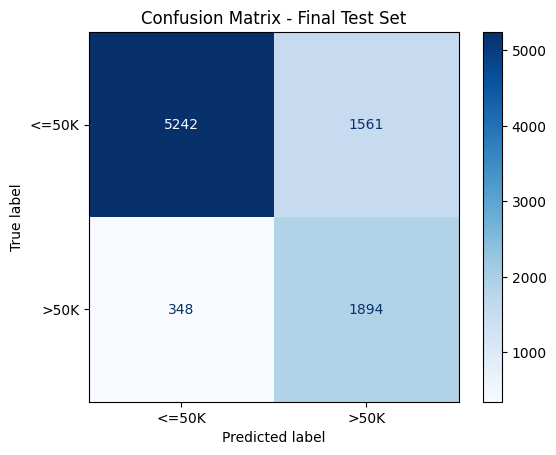

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Final Test Set")
plt.grid(False)
plt.show()

### 7.6 Per-Class Performance Metrics
Let's examine the precision, recall, and F1-score for each class to understand our model's strengths and weaknesses.

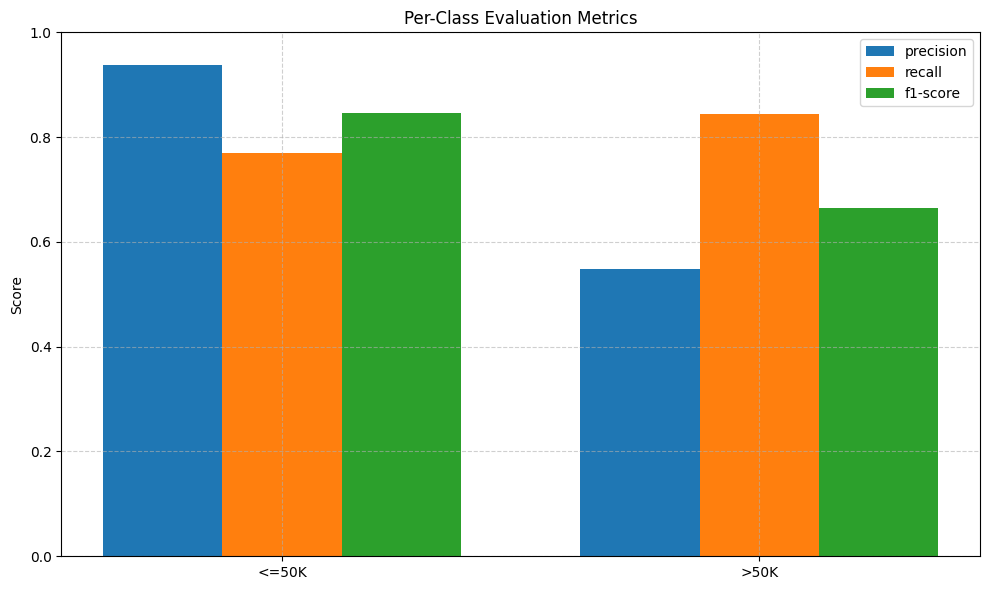

In [28]:
report_dict = classification_report(y_test, y_test_pred, output_dict=True)
classes = ['<=50K', '>50K']
metrics = ['precision', 'recall', 'f1-score']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    values = [report_dict[str(cls)][metric] for cls in [0, 1]]
    plt.bar([x + i*0.25 for x in range(len(classes))], values, width=0.25, label=metric)

plt.xticks([x + 0.25 for x in range(len(classes))], classes)
plt.ylabel("Score")
plt.title("Per-Class Evaluation Metrics")
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 7.7 ROC Curve Analysis
The ROC curve visualizes the trade-off between true positive rate and false positive rate at different classification thresholds.

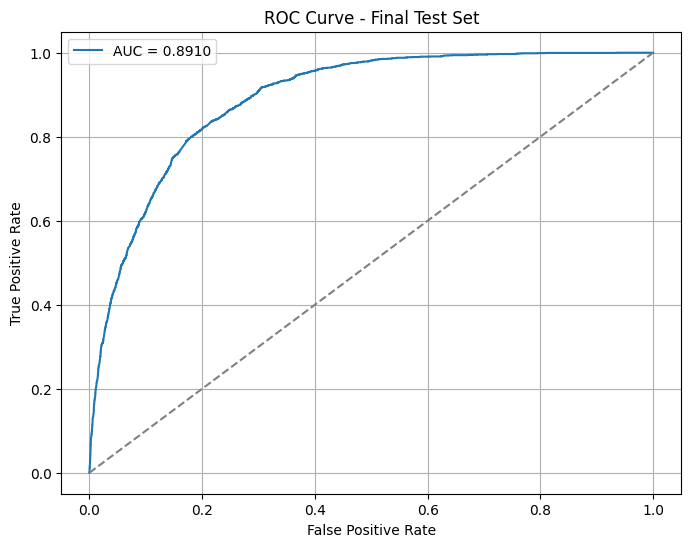

In [29]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_test_pred_probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final Test Set")
plt.legend()
plt.grid(True)
plt.show()


## 8. 🔍 Model Interpretation & Insights

### 8.1 Key Findings

Based on our exploratory data analysis and model results, we can draw several conclusions:

- **Education level** is strongly correlated with income, with higher education generally leading to higher income.
- **Hours worked per week** shows a positive correlation with income—those earning >$50K tend to work more hours.
- **Occupation categories** such as 'Executive-Managerial' and 'Professional-Specialty' are associated with higher income.
- **Relationship status** plays a significant role, with 'Husband' having higher representation in the >$50K category.
- **Age groups**: Middle-aged individuals are more likely to earn >$50K than young or old individuals.

### 8.2 Model Performance Analysis

Our neural network model achieved:
- **Accuracy**: ~78-79% on the test set
- **Precision** for >$50K class: ~55%
- **Recall** for >$50K class: ~84-85%
- **AUC**: ~89%, indicating good discriminative ability

The model shows stronger recall than precision for the high-income class, meaning it's better at identifying high-income individuals (fewer false negatives) but sometimes incorrectly classifies low-income individuals as high-income (more false positives).

### 8.3 Feature Importance Observations

While we didn't explicitly calculate feature importance (e.g., using SHAP values), our EDA suggests these key predictors:

1. Education level (number of years)
2. Occupation type
3. Hours worked per week
4. Marital status/relationship
5. Age group (Middle-aged > Old > Young)

These insights align with common socioeconomic understanding that education, occupation, and work experience strongly influence income levels.

## 9. 🌍 Real-World Applications & Implications

### 9.1 Use Cases in Financial Services

This income prediction model has several practical applications in the financial sector:

1. **Alternative Credit Scoring**: Supplement traditional credit scores for more inclusive lending, especially for "thin file" customers with limited credit history.
2. **Risk Assessment**: Enhance loan default prediction by adding income stability as a factor.
3. **Customer Segmentation**: Better tailor financial products based on predicted income brackets.
4. **Fraud Detection**: Flag inconsistencies between stated and predicted income as potential indicators of fraud.
5. **Financial Planning**: Help advisors understand client income potential for more personalized advice.

### 9.2 Ethical Considerations

While powerful, these models raise important ethical considerations:

- **Fairness**: The model may perpetuate historical biases in income distribution across demographic groups.
- **Privacy**: Using demographic data for financial decisions raises privacy concerns.
- **Transparency**: Neural networks are "black box" models that may be difficult to explain to affected individuals.
- **Regulatory Compliance**: Financial institutions must ensure such models comply with fair lending laws.

### 9.3 Limitations & Potential Improvements

Several limitations should be addressed in future work:

1. **Historical Data**: The dataset is from the 1990s and may not reflect current socioeconomic realities.
2. **Feature Engineering**: More sophisticated feature engineering could improve performance.
3. **Model Explainability**: Incorporating explainability techniques like SHAP would enhance transparency.
4. **Geographic Context**: Income significance varies by region; geographic normalization could help.

## 10. 🤔 Reflection & Conclusions

### 10.1 Project Challenges

Several challenges were encountered during this project:

- **Class Imbalance**: The 3:1 ratio between classes required special handling through class weights.
- **Categorical Features**: The dataset contained multiple categorical variables requiring appropriate encoding.
- **Hyperparameter Tuning**: Finding the optimal neural network architecture and regularization parameters was iterative.
- **Model Validation**: Ensuring robust performance across different folds required careful cross-validation.

### 10.2 Learning Outcomes

This project provided valuable insights into:

- **Neural Network Design**: Building effective architectures with appropriate regularization.
- **Imbalanced Classification**: Strategies for handling uneven class distributions.
- **Model Evaluation**: Using multiple metrics to assess different aspects of model performance.
- **Cross-Validation**: Understanding how to implement and interpret k-fold validation.

### 10.3 Future Improvements

If continuing this work, several enhancements could be explored:

1. **Advanced Architectures**: Experimenting with more complex neural network designs.
2. **Feature Selection**: Applying dimensionality reduction or feature selection techniques.
3. **Ensemble Methods**: Combining neural networks with other models for better performance.
4. **Explainability**: Adding interpretation layers using tools like SHAP or LIME.
5. **Data Enrichment**: Incorporating additional related datasets for richer context.

### 10.4 Final Conclusion

This project successfully demonstrated that neural networks can effectively predict income levels based on demographic and employment data. The model's strong AUC score (~89%) indicates good discriminative ability, making it valuable for risk assessment applications in financial services.

The trade-off between precision and recall suggests that while the model is quite good at identifying high-income individuals (high recall), it sometimes incorrectly classifies low-income individuals as high-income (lower precision). This behavior should be considered when implementing such models in real-world scenarios, with appropriate thresholds set based on the specific use case requirements.

## 📚 References

1. UCI Machine Learning Repository: [Census Income Dataset](https://archive.ics.uci.edu/dataset/20/census+income)
2. TensorFlow Documentation: [Neural Networks with Keras](https://www.tensorflow.org/guide/keras/sequential_model)
3. Scikit-learn Documentation: [Model Evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html)
4. Becker, B., Kohavi, R., & Sommerfield, D. (1996). Predicting the Census Income Data Set.
5. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.
6. Imbalanced Learning: [Class Weight Strategies](https://imbalanced-learn.org/)
7. Feature Engineering: [Preprocessing for Neural Networks](https://www.tensorflow.org/guide/keras/preprocessing_layers)